<a href="https://colab.research.google.com/drive/1LJToCKwnublp8ITrLWFHZhn6jHVivG-l?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Topic Modeling** 
is a technique to extract the hidden topics from large volumes of text. Latent Dirichlet Allocation(LDA) is a popular algorithm for topic modeling with excellent implementations in the Python’s Gensim package. 

The challenge, however, is how to extract good quality of topics that are clear, segregated and meaningful. This depends heavily on the quality of text preprocessing and the strategy of finding the optimal number of topics.

# **LDA Mallet Model (NGRAMS)**

In this notebook, we present the approach of using **NGRAMS (1-gram, 2-grams and 3-grams) + NOUNS only** approach to build a LDA topic model using the LDA Mallet.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. We only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.Lda3Mallet.

## **Import Libraries, Packages and Data**

**Install JAVA**

In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.14" 2022-01-18
OpenJDK Runtime Environment (build 11.0.14+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.14+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


**Install & Unpack LDA Mallet**

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2022-03-21 13:49:39--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-03-21 13:49:40--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip.1’

mallet-2.0.8.zip.1  100%[===================>]  15.43M  5.46MB/s    in 2.8s    

2022-03-21 13:49:43 (5.46 MB/s) - ‘mallet-2.0.8.zip.1’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
replace mallet-2.0.8/bin/classifier2info? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' 

**Import Libraries & Packages**

In [ ]:
!pip install pyLDAvis

import pandas as pd
import numpy as np
from pprint import pprint

import gensim
from gensim import corpora
from gensim.models import CoherenceModel

from nltk.tokenize import sent_tokenize, word_tokenize

import nltk
nltk.download('punkt')

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Mount to GDrive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Data**

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Hotel_Analysis/Hotel_Datasets/515k_Hotel_Reviews_NOUNS_TOKENS.csv'
df = pd.read_csv(path)
df.head(5)

,cleaned_Reviews
0,"['hotel', 'mess', 'hotel', 'star']"
1,"['change', 'sheet', 'duvet', 'everyday', 'bed'..."
2,"['price', 'brekfast']"
3,"['picture', 'room', 'room', 'quit', 'dirty', '..."
4,"['aircondition', 'sleep', 'night']"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545181 entries, 0 to 545180
Data columns (total 1 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   cleaned_Reviews  545181 non-null  object
dtypes: object(1)
memory usage: 4.2+ MB


**10000 random samples for Topic Modelling**

In [ ]:
# Obtain a sample for topic model building

df_sample = df.sample(10000, random_state=120)

In [ ]:
# Reset index
df_sample = df_sample.reset_index(drop=True)

In [ ]:
df_sample

,cleaned_Reviews
0,"['service', 'gave_u_free', 'bottle', 'room', '..."
1,"['room', 'immaculate', 'bar', 'view', 'oxford_..."
2,"['hotel', 'room', 'bed', 'bathroom', 'term', '..."
3,"['city', 'grea', 'thotel']"
4,"['front_desk', 'help', 'delight', 'stay', 'mor..."
...,...
9995,"['room', 'bathroom', 'room', 'word', 'describe..."
9996,"['staff', 'roof_terrace']"
9997,['staff']
9998,"['hotel', 'night']"


## **Reviews Pre-processing**

**Remove Punctuations**

In [ ]:
df_sample["Reviews"] = df_sample['cleaned_Reviews'].str.replace('[^\w\s]','')

<input>:1: DeprecationWarning: invalid escape sequence \w
<ipython-input-12-1e9b69d4e2be>:1: DeprecationWarning: invalid escape sequence \w
  df_sample["Reviews"] = df_sample['cleaned_Reviews'].str.replace('[^\w\s]','')
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
df_sample

,cleaned_Reviews,Reviews
0,"['service', 'gave_u_free', 'bottle', 'room', '...",service gave_u_free bottle room victoria spong...
1,"['room', 'immaculate', 'bar', 'view', 'oxford_...",room immaculate bar view oxford_street recepti...
2,"['hotel', 'room', 'bed', 'bathroom', 'term', '...",hotel room bed bathroom term hotel experience ...
3,"['city', 'grea', 'thotel']",city grea thotel
4,"['front_desk', 'help', 'delight', 'stay', 'mor...",front_desk help delight stay morning brekfast ...
...,...,...
9995,"['room', 'bathroom', 'room', 'word', 'describe...",room bathroom room word describe night ventila...
9996,"['staff', 'roof_terrace']",staff roof_terrace
9997,['staff'],staff
9998,"['hotel', 'night']",hotel night


**Create Dataframe of Reviews**

In [ ]:
reviews = df_sample.Reviews
reviews

0       service gave_u_free bottle room victoria spong...
1       room immaculate bar view oxford_street recepti...
2       hotel room bed bathroom term hotel experience ...
3                                        city grea thotel
4       front_desk help delight stay morning brekfast ...
                              ...                        
9995    room bathroom room word describe night ventila...
9996                                   staff roof_terrace
9997                                                staff
9998                                          hotel night
9999                   breakfast hotel room staff helpful
Name: Reviews, Length: 10000, dtype: object

**Convert reviews dataframe to list**

In [ ]:
reviews = reviews.tolist()

**Tokenize the sentence into words**

In [ ]:
import string 

#Tokenize the sentence into words
reviews_tokens = [word_tokenize(t) for t in reviews]

**Samples of reviews tokens**

In [ ]:
reviews_tokens[:5]

[['service', 'gave_u_free', 'bottle', 'room', 'victoria', 'sponge', 'thank'],
 ['room',
  'immaculate',
  'bar',
  'view',
  'oxford_street',
  'reception',
  'delightful',
  'shop',
  'rest',
  'shop',
  'palladium',
  'dinner',
  'grill',
  'bus',
  'street'],
 ['hotel',
  'room',
  'bed',
  'bathroom',
  'term',
  'hotel',
  'experience',
  'bathrobe_slipper',
  'room',
  'commend',
  'spa',
  'space'],
 ['city', 'grea', 'thotel'],
 ['front_desk',
  'help',
  'delight',
  'stay',
  'morning',
  'brekfast',
  'delight',
  'morning']]

**Create a dictionary (mapping between words and their integer ids)**

In [ ]:
dictionary = corpora.Dictionary(reviews_tokens)            

**Converts the word to its integer word id and returns the result as a sparse vector (using Doc2bow Doc term matrix)**

In [ ]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in reviews_tokens]

**Samples of doc_term_matrix (corpus)**

In [ ]:
doc_term_matrix[:5]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)],
 [(2, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 2),
  (18, 1),
  (19, 1)],
 [(2, 2),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 2),
  (26, 1),
  (27, 1),
  (28, 1)],
 [(29, 1), (30, 1), (31, 1)],
 [(32, 1), (33, 2), (34, 1), (35, 1), (36, 2), (37, 1)]]

**Human readable format of corpus**

In [ ]:
# Human readable format of corpus
[[(dictionary[id], freq) for id, freq in cp] for cp in doc_term_matrix[:5]]

[[('bottle', 1),
  ('gave_u_free', 1),
  ('room', 1),
  ('service', 1),
  ('sponge', 1),
  ('thank', 1),
  ('victoria', 1)],
 [('room', 1),
  ('bar', 1),
  ('bus', 1),
  ('delightful', 1),
  ('dinner', 1),
  ('grill', 1),
  ('immaculate', 1),
  ('oxford_street', 1),
  ('palladium', 1),
  ('reception', 1),
  ('rest', 1),
  ('shop', 2),
  ('street', 1),
  ('view', 1)],
 [('room', 2),
  ('bathrobe_slipper', 1),
  ('bathroom', 1),
  ('bed', 1),
  ('commend', 1),
  ('experience', 1),
  ('hotel', 2),
  ('spa', 1),
  ('space', 1),
  ('term', 1)],
 [('city', 1), ('grea', 1), ('thotel', 1)],
 [('brekfast', 1),
  ('delight', 2),
  ('front_desk', 1),
  ('help', 1),
  ('morning', 2),
  ('stay', 1)]]

## **Model Building**

**Compute coherence score for models with different number of topics (Try from 2 topics - 40 topics)**

In [ ]:
# Compute coherence score for models with different number of topics
# Try from 2 topics - 40 topics

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=reviews_tokens, start=2, limit=40, step=2)

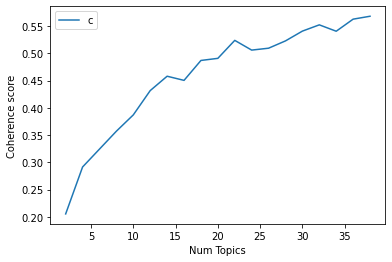

In [ ]:
# Show graph

limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show() 
sns.set(rc = {'figure.figsize':(15,8)})

In [ ]:
# Print the coherence scores

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2054
Num Topics = 4  has Coherence Value of 0.2914
Num Topics = 6  has Coherence Value of 0.3243
Num Topics = 8  has Coherence Value of 0.3571
Num Topics = 10  has Coherence Value of 0.387
Num Topics = 12  has Coherence Value of 0.4315
Num Topics = 14  has Coherence Value of 0.4579
Num Topics = 16  has Coherence Value of 0.4503
Num Topics = 18  has Coherence Value of 0.4868
Num Topics = 20  has Coherence Value of 0.4907
Num Topics = 22  has Coherence Value of 0.5237
Num Topics = 24  has Coherence Value of 0.5058
Num Topics = 26  has Coherence Value of 0.5093
Num Topics = 28  has Coherence Value of 0.5227
Num Topics = 30  has Coherence Value of 0.5406
Num Topics = 32  has Coherence Value of 0.5521
Num Topics = 34  has Coherence Value of 0.5404
Num Topics = 36  has Coherence Value of 0.5626
Num Topics = 38  has Coherence Value of 0.5679


Finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

Upon observation, we decided to go with Num Topics = 20, as at this number of topic, the coherence score of the model managed to achieve its highest at 0.4947. After this number of topics, the coherence score of number of topics above this number 'flattens out' to around 0.50+-.

We will be choosing the least number of topic before the coherence scores 'flattens out', which is Num Topics = 20.

## **Topic Model with Num Topic = 20**

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=20, id2word=dictionary)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(9,
  [('bathroom', 0.25377015080603227),
   ('shower', 0.10140405616224649),
   ('room', 0.09256370254810192),
   ('water', 0.07020280811232449),
   ('door', 0.058242329693187725),
   ('bath', 0.0452418096723869),
   ('smell', 0.0265210608424337),
   ('towel', 0.0234009360374415),
   ('glass', 0.019760790431617263),
   ('travel', 0.010400416016640665)]),
 (10,
  [('bed', 0.398717263495457),
   ('comfy', 0.12453233564938536),
   ('pillow', 0.028327097808658473),
   ('value_money', 0.021378941742383754),
   ('balcony', 0.02084446819882416),
   ('area', 0.016568679850347406),
   ('shopping', 0.016568679850347406),
   ('super', 0.014430785676109033),
   ('pool', 0.014430785676109033),
   ('mattress', 0.013361838588989846)]),
 (7,
  [('hotel', 0.28921819110884006),
   ('view', 0.1548288196218702),
   ('location', 0.08993357179356157),
   ('city', 0.06745017884517118),
   ('kind', 0.03474706182933061),
   ('centre', 0.021972406745017884),
   ('town', 0.01481859989780276),
   ('river', 0.01

**Convert to LDA format (to display pyLDAvis)**

In [ ]:
lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

**Save & Load the model**

In [ ]:
# Save & Load the model
lda_model.save('/content/drive/MyDrive/Colab Notebooks/Hotel_Analysis/Topic Modelling/Topic Models/LDAmallet_NOUNS')
lda_model = gensim.models.ldamodel.LdaModel.load('/content/drive/MyDrive/Colab Notebooks/Hotel_Analysis/Topic Modelling/Topic Models/LDAmallet_NOUNS')

**Compute Coherence Score**

In [ ]:
# Compute Coherence Score
coherence_model_ldamodel = CoherenceModel(model=lda_model, texts=reviews_tokens, dictionary=dictionary, coherence='c_v')
coherence_ldamodel = coherence_model_ldamodel.get_coherence()
print('\nCoherence Score: ', coherence_ldamodel)


Coherence Score:  0.511010535895693


## **Visualize the topics using pyLDAvis**

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary, sort_topics=False)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.002789  0.228884       1        1  5.002278
1      0.225115 -0.141404       2        1  4.951940
2     -0.005516  0.119727       3        1  5.050848
3     -0.314329 -0.140457       4        1  4.997295
4     -0.224574 -0.073790       5        1  4.940977
5     -0.230749 -0.107541       6        1  5.051760
6     -0.302829 -0.133943       7        1  5.016871
7      0.086320  0.242626       8        1  5.056898
8      0.221702 -0.141020       9        1  4.955557
9     -0.001614  0.230118      10        1  4.988133
10    -0.016266  0.110424      11        1  5.080580
11    -0.076542  0.061705      12        1  5.011292
12     0.310014 -0.056279      13        1  4.920791
13     0.060767  0.238758      14        1  5.020672
14     0.299448 -0.214504      15        1  4.902278
15    -0.273507 -0.098160      16        1  5.034452
16    -0.264012 -0.094498      17        1  5.037869
17     0.313699 -0.218433      18        1  4.918069
18     0.129026 -0.070064      19        1  5.027750
19     0.066635  0.257850      20        1  5.033691, topic_info=          Term         Freq        Total Category  logprob  loglift
2         room  3965.000000  3965.000000  Default  30.0000  30.0000
54       staff  2758.000000  2758.000000  Default  29.0000  29.0000
48   breakfast  1583.000000  1583.000000  Default  28.0000  28.0000
50    location  2368.000000  2368.000000  Default  27.0000  27.0000
25       hotel  1802.000000  1802.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
25       hotel   510.075754  1802.806854  Topic20  -1.3562   1.7265
431     milano     9.236784    11.243307  Topic20  -5.3675   2.7924
364        air    14.368331    22.798764  Topic20  -4.9257   2.5273
545    deposit     8.210475    12.399468  Topic20  -5.4853   2.5768
53      london    12.315712   108.749217  Topic20  -5.0799   0.8108

[1216 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
2200      9  0.992293               abit
374       3  0.014666             access
374       8  0.806603             access
374      19  0.190652             access
660      10  0.977657      accommodation
...     ...       ...                ...
638       9  0.992293            yasmine
966      14  1.004436               year
967      10  0.977657  year_old_daughter
723       4  0.992146               yolk
1063     17  0.954883              yummy

[1507 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

**Save visualiation as HTML file**

In [ ]:
pyLDAvis.save_html(vis, '/content/drive/MyDrive/Colab Notebooks/Hotel_Analysis/Topic Modelling/Topic Models/lda.html')

**Observation of Topics:**

We managed to obtain a very diverse range of topics. This can be seen from the intertopic distance visualisation. Although there are clustering of various topics in a single topic, we may be able to find out specific characteristics of each topic upon further discovery. 

What this means is, one topic may be referring to the 'hotel room size', whilst another may be referring to the 'hotel room bathroom'. Both topics may contain similar words, such as, 'room', however, they may be referring to similar yet completely different subjects.

As such, we will be drilling deeper into finding out what each topics are referring to the **Topic Distribution (Interpretation of Topic Model)** workbook.